In [2]:
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
from pandas import isnull
from numpy import count_nonzero
from pyspark.sql.functions import col, count, isnan, when, coalesce, lag, lead, sum
from pyspark.sql.window import Window

import warnings
warnings.filterwarnings("ignore")

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [4]:
# Load the dataset
data_frame1 = spark.read.csv("Dataset/col_mat_nuw_output.csv", header=True, inferSchema=True)

In [5]:
data_frame1.printSchema()

root
 |-- 0.00019698343957810148: double (nullable = true)
 |-- Colombo Proper: string (nullable = true)
 |-- 2019-01-01: date (nullable = true)
 |-- 2019-01-02: date (nullable = true)



In [6]:
data_frame1.show()

+----------------------+--------------+----------+----------+
|0.00019698343957810148|Colombo Proper|2019-01-01|2019-01-02|
+----------------------+--------------+----------+----------+
|  2.625522171968594...|Colombo Proper|2019-01-02|2019-01-03|
|  9.852118897938794E-5|Colombo Proper|2019-01-03|2019-01-04|
|  2.099320518114242E-4|Colombo Proper|2019-01-04|2019-01-05|
|  1.785337298892930...|Colombo Proper|2019-01-05|2019-01-06|
|  1.082296700235670...|Colombo Proper|2019-01-06|2019-01-07|
|  3.926829280477309...|Colombo Proper|2019-01-07|2019-01-08|
|  9.153156350685351E-5|Colombo Proper|2019-01-08|2019-01-09|
|  1.205978992853015...|Colombo Proper|2019-01-09|2019-01-10|
|  1.297723562983258...|Colombo Proper|2019-01-10|2019-01-11|
|  2.239188166801278...|Colombo Proper|2019-01-11|2019-01-12|
|  1.569418094178759...|Colombo Proper|2019-01-12|2019-01-13|
|                  NULL|Colombo Proper|2019-01-13|2019-01-14|
|  1.336291906862603...|Colombo Proper|2019-01-14|2019-01-15|
|  6.374

In [7]:
column_name = ['HCHO reading', 'Location', 'Current Date', 'Next Date']

# Rename columns using withColumnRenamed()
for i, new_name in enumerate(column_name):
    data_frame1 = data_frame1.withColumnRenamed(data_frame1.columns[i], new_name)

# Display the DataFrame
data_frame1.show()

+--------------------+--------------+------------+----------+
|        HCHO reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.336291906862603...|Colombo Proper|  2019-01-14|2019-01-15|
|6.37441

In [8]:
from pyspark.sql.functions import col, sum as spark_sum, when
columns = data_frame1.columns

# Calculate missing values for each column
missing_counts = data_frame1.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns])

# Show missing counts
missing_counts.show()

+------------+--------+------------+---------+
|HCHO reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|        2419|       0|           0|        0|
+------------+--------+------------+---------+



In [9]:
# Initialize a counter for null values
null_count = data_frame1.filter(col("HCHO reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO reading", 1).over(backward_windowSpec)
    data_frame1 = data_frame1.withColumn("HCHO reading", coalesce("HCHO reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO reading", 1).over(forward_windowSpec)
    data_frame1 = data_frame1.withColumn("HCHO reading", coalesce("HCHO reading", next_value))
    
    # Update the null count
    null_count = data_frame1.filter(col("HCHO reading").isNull()).count()


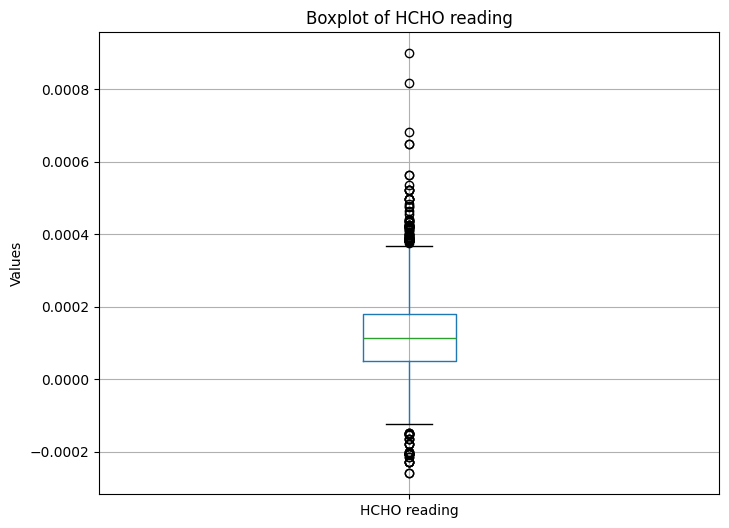

In [10]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pandas_df1 = data_frame1.toPandas()

feature = "HCHO reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df1.boxplot(column=[feature])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

In [11]:
import numpy as np


# Extracting the HCHO readings
hcho_readings = pandas_df1[feature]

# Calculating quartiles and IQR
Q1 = hcho_readings.quantile(0.25)
Q3 = hcho_readings.quantile(0.75)
IQR = Q3 - Q1

# Defining outlier thresholds
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

# Counting outliers
outliers_frequency = ((hcho_readings < lower_threshold) | (hcho_readings > upper_threshold)).sum()

print("Frequency of outliers:", outliers_frequency)


Frequency of outliers: 112


In [12]:
# Define the Winsorization function
def winsorize(series, lower_threshold, upper_threshold):
    # Winsorize the series
    winsorized_series = series.clip(lower=lower_threshold, upper=upper_threshold)
    return winsorized_series

# Apply Winsorization to handle outliers
pandas_df1[feature] = winsorize(pandas_df1[feature], lower_threshold, upper_threshold)

# Recalculate the frequency of outliers after Winsorization
outliers_after_winsorization = ((pandas_df1[feature] < lower_threshold) | (pandas_df1[feature] > upper_threshold)).sum()

print("Frequency of outliers after Winsorization:", outliers_after_winsorization)


Frequency of outliers after Winsorization: 0


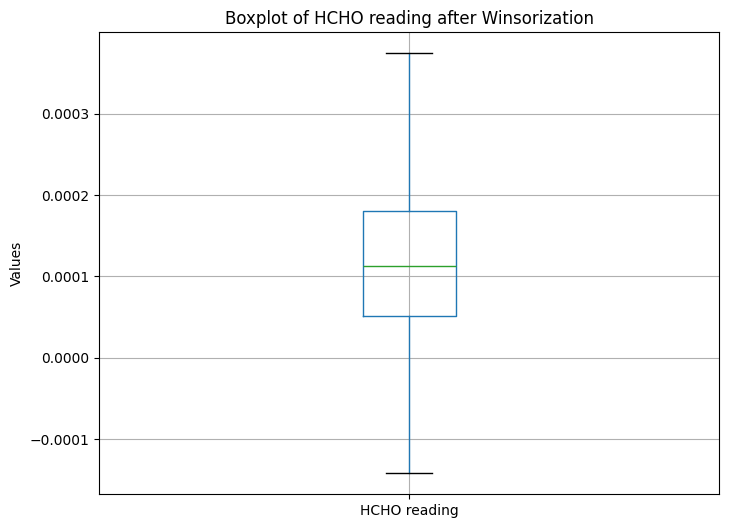

In [13]:
# After handling the outlier of data frame 1
plt.figure(figsize=(8, 6))
pandas_df1.boxplot(column=[feature])
plt.title(f'Boxplot of {feature} after Winsorization')
plt.ylabel('Values')
plt.show()

In [14]:
import pandas as pd

dates = pandas_df1['Current Date']

for date in sorted(dates.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [15]:
import pandas as pd

dates_2 = pandas_df1['Next Date']

for date in sorted(dates_2.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [16]:
pandas_df1

,HCHO reading,Location,Current Date,Next Date
0,0.000263,"Deniyaya, Matara",2019-01-01,2019-01-02
1,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
2,0.000263,Colombo Proper,2019-01-02,2019-01-03
3,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03
4,0.000006,Nuwara Eliya Proper,2019-01-02,2019-01-03
...,...,...,...,...
5472,0.000116,"Deniyaya, Matara",2023-12-30,2023-12-31
5473,0.000116,Nuwara Eliya Proper,2023-12-30,2023-12-31
5474,0.000080,Colombo Proper,2023-12-31,2024-01-01
5475,0.000080,"Deniyaya, Matara",2023-12-31,2024-01-01


In [17]:
data_frame2 = spark.read.csv("Dataset/kan_output.csv", header=True, inferSchema=True)
data_frame2.printSchema()

root
 |-- 0.00017607134598773356: double (nullable = true)
 |-- Kandy Proper: string (nullable = true)
 |-- 2019-01-01: date (nullable = true)
 |-- 2019-01-02: date (nullable = true)



In [18]:
data_frame2.show()

+----------------------+------------+----------+----------+
|0.00017607134598773356|Kandy Proper|2019-01-01|2019-01-02|
+----------------------+------------+----------+----------+
|  9.220391253917748E-5|Kandy Proper|2019-01-02|2019-01-03|
|                  NULL|Kandy Proper|2019-01-03|2019-01-04|
|  1.908681983853839...|Kandy Proper|2019-01-04|2019-01-05|
|  1.219517840206744...|Kandy Proper|2019-01-05|2019-01-06|
|  -6.51408612938880...|Kandy Proper|2019-01-06|2019-01-07|
|    1.6323820639265E-4|Kandy Proper|2019-01-07|2019-01-08|
|  -6.73520553391426...|Kandy Proper|2019-01-08|2019-01-09|
|  1.279693658243135...|Kandy Proper|2019-01-09|2019-01-10|
|  4.546048424126012E-5|Kandy Proper|2019-01-10|2019-01-11|
|  3.600074175192105E-5|Kandy Proper|2019-01-11|2019-01-12|
|  1.286629698010177E-4|Kandy Proper|2019-01-12|2019-01-13|
|                  NULL|Kandy Proper|2019-01-13|2019-01-14|
|                  NULL|Kandy Proper|2019-01-14|2019-01-15|
|   9.63639634671553E-5|Kandy Proper|201

In [19]:
column_name = ['HCHO reading', 'Location', 'Current Date', 'Next Date']

# Rename columns using withColumnRenamed()
for i, new_name in enumerate(column_name):
    data_frame2 = data_frame2.withColumnRenamed(data_frame2.columns[i], new_name)

# Display the DataFrame
data_frame2.show()

+--------------------+------------+------------+----------+
|        HCHO reading|    Location|Current Date| Next Date|
+--------------------+------------+------------+----------+
|9.220391253917748E-5|Kandy Proper|  2019-01-02|2019-01-03|
|                NULL|Kandy Proper|  2019-01-03|2019-01-04|
|1.908681983853839...|Kandy Proper|  2019-01-04|2019-01-05|
|1.219517840206744...|Kandy Proper|  2019-01-05|2019-01-06|
|-6.51408612938880...|Kandy Proper|  2019-01-06|2019-01-07|
|  1.6323820639265E-4|Kandy Proper|  2019-01-07|2019-01-08|
|-6.73520553391426...|Kandy Proper|  2019-01-08|2019-01-09|
|1.279693658243135...|Kandy Proper|  2019-01-09|2019-01-10|
|4.546048424126012E-5|Kandy Proper|  2019-01-10|2019-01-11|
|3.600074175192105E-5|Kandy Proper|  2019-01-11|2019-01-12|
|1.286629698010177E-4|Kandy Proper|  2019-01-12|2019-01-13|
|                NULL|Kandy Proper|  2019-01-13|2019-01-14|
|                NULL|Kandy Proper|  2019-01-14|2019-01-15|
| 9.63639634671553E-5|Kandy Proper|  201

In [20]:
from pyspark.sql.functions import col, sum as spark_sum, when
columns = data_frame2.columns

# Calculate missing values for each column
missing_counts = data_frame2.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns])

# Show missing counts
missing_counts.show()

+------------+--------+------------+---------+
|HCHO reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|         793|       0|           0|        0|
+------------+--------+------------+---------+



In [21]:
# Initialize a counter for null values
null_count = data_frame2.filter(col("HCHO reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO reading", 1).over(backward_windowSpec)
    data_frame2 = data_frame2.withColumn("HCHO reading", coalesce("HCHO reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO reading", 1).over(forward_windowSpec)
    data_frame2 = data_frame2.withColumn("HCHO reading", coalesce("HCHO reading", next_value))
    
    # Update the null count
    null_count = data_frame2.filter(col("HCHO reading").isNull()).count()


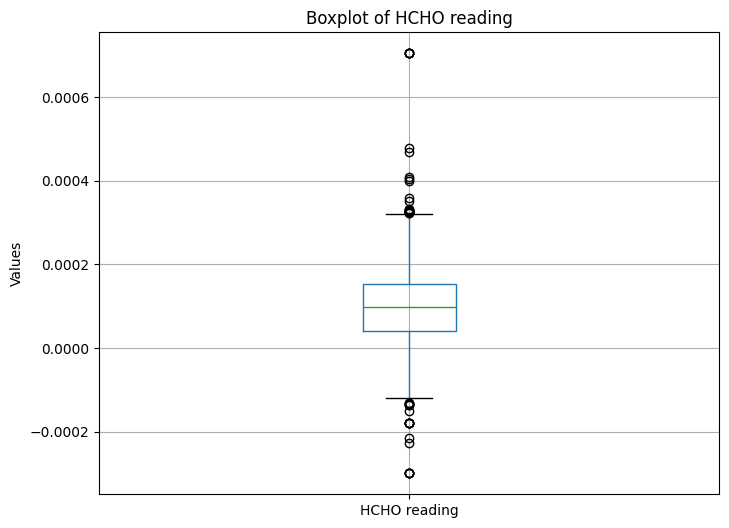

In [22]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pandas_df2 = data_frame2.toPandas()

feature_2 = "HCHO reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df2.boxplot(column=[feature_2])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

In [23]:
hcho_readings_2 = pandas_df2[feature_2]

# Calculating quartiles and IQR
Q1_2 = hcho_readings_2.quantile(0.25)
Q3_2 = hcho_readings_2.quantile(0.75)
IQR_2 = Q3_2 - Q1_2

# Defining outlier thresholds
lower_threshold_2 = Q1_2 - 1.5 * IQR_2
upper_threshold_2 = Q3_2 + 1.5 * IQR_2

# Counting outliers
outliers_frequency_2 = ((hcho_readings_2 < lower_threshold_2) | (hcho_readings_2 > upper_threshold_2)).sum()

print("Frequency of outliers in feature_2:", outliers_frequency_2)

Frequency of outliers in feature_2: 43


In [24]:
# Define the Winsorization function
def winsorize(series, lower_threshold, upper_threshold):
    # Winsorize the series
    winsorized_series = series.clip(lower=lower_threshold, upper=upper_threshold)
    return winsorized_series

# Apply Winsorization to handle outliers
pandas_df2[feature_2] = winsorize(pandas_df2[feature_2], lower_threshold_2, upper_threshold_2)

# Recalculate the frequency of outliers after Winsorization
outliers_after_winsorization_2 = ((pandas_df2[feature_2] < lower_threshold_2) | (pandas_df2[feature_2] > upper_threshold_2)).sum()

print("Frequency of outliers after Winsorization in feature_2:", outliers_after_winsorization_2)


Frequency of outliers after Winsorization in feature_2: 0


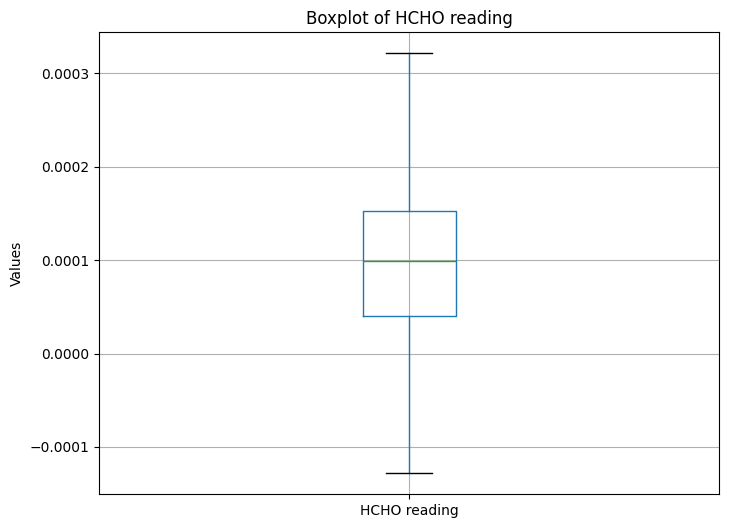

In [25]:
# After handling the outlier of data frame 2 
feature_2 = "HCHO reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df2.boxplot(column=[feature_2])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

In [26]:
import pandas as pd

dates = pandas_df2['Next Date']

for date in sorted(dates.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [27]:
import pandas as pd

dates = pandas_df2['Current Date']

for date in sorted(dates.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [28]:
pandas_df2

,HCHO reading,Location,Current Date,Next Date
0,0.000092,Kandy Proper,2019-01-02,2019-01-03
1,0.000092,Kandy Proper,2019-01-03,2019-01-04
2,0.000191,Kandy Proper,2019-01-04,2019-01-05
3,0.000122,Kandy Proper,2019-01-05,2019-01-06
4,-0.000065,Kandy Proper,2019-01-06,2019-01-07
...,...,...,...,...
1820,0.000056,Kandy Proper,2023-12-27,2023-12-28
1821,0.000056,Kandy Proper,2023-12-28,2023-12-29
1822,0.000056,Kandy Proper,2023-12-29,2023-12-30
1823,0.000056,Kandy Proper,2023-12-30,2023-12-31


In [29]:
data_frame3 = spark.read.csv("Dataset/mon_kur_jaf_output.csv", header=True, inferSchema=True)
data_frame3.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- Bibile, Monaragala: string (nullable = true)
 |-- 2019-01-01: date (nullable = true)
 |-- 2019-01-02: date (nullable = true)



In [30]:
data_frame3.show()

+--------------------+------------------+----------+----------+
|                 _c0|Bibile, Monaragala|2019-01-01|2019-01-02|
+--------------------+------------------+----------+----------+
|1.919914652467399E-5|Bibile, Monaragala|2019-01-02|2019-01-03|
|2.811447935930283...|Bibile, Monaragala|2019-01-03|2019-01-04|
|3.747998184385943E-5|Bibile, Monaragala|2019-01-04|2019-01-05|
|-1.79826087934531...|Bibile, Monaragala|2019-01-05|2019-01-06|
|1.457836896179902...|Bibile, Monaragala|2019-01-06|2019-01-07|
|2.828590802546534...|Bibile, Monaragala|2019-01-07|2019-01-08|
|                NULL|Bibile, Monaragala|2019-01-08|2019-01-09|
|1.420850167050957...|Bibile, Monaragala|2019-01-09|2019-01-10|
|                NULL|Bibile, Monaragala|2019-01-10|2019-01-11|
|2.014587947072581E-5|Bibile, Monaragala|2019-01-11|2019-01-12|
|1.582787663210183...|Bibile, Monaragala|2019-01-12|2019-01-13|
|                NULL|Bibile, Monaragala|2019-01-13|2019-01-14|
|                NULL|Bibile, Monaragala

In [31]:
column_name = ['HCHO reading', 'Location', 'Current Date', 'Next Date']

# Rename columns using withColumnRenamed()
for i, new_name in enumerate(column_name):
    data_frame3 = data_frame3.withColumnRenamed(data_frame3.columns[i], new_name)

# Display the DataFrame
data_frame3.show()

+--------------------+------------------+------------+----------+
|        HCHO reading|          Location|Current Date| Next Date|
+--------------------+------------------+------------+----------+
|1.919914652467399E-5|Bibile, Monaragala|  2019-01-02|2019-01-03|
|2.811447935930283...|Bibile, Monaragala|  2019-01-03|2019-01-04|
|3.747998184385943E-5|Bibile, Monaragala|  2019-01-04|2019-01-05|
|-1.79826087934531...|Bibile, Monaragala|  2019-01-05|2019-01-06|
|1.457836896179902...|Bibile, Monaragala|  2019-01-06|2019-01-07|
|2.828590802546534...|Bibile, Monaragala|  2019-01-07|2019-01-08|
|                NULL|Bibile, Monaragala|  2019-01-08|2019-01-09|
|1.420850167050957...|Bibile, Monaragala|  2019-01-09|2019-01-10|
|                NULL|Bibile, Monaragala|  2019-01-10|2019-01-11|
|2.014587947072581E-5|Bibile, Monaragala|  2019-01-11|2019-01-12|
|1.582787663210183...|Bibile, Monaragala|  2019-01-12|2019-01-13|
|                NULL|Bibile, Monaragala|  2019-01-13|2019-01-14|
|         

In [32]:
from pyspark.sql.functions import col, sum as spark_sum, when
columns = data_frame3.columns

# Calculate missing values for each column
missing_counts = data_frame3.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns])

# Show missing counts
missing_counts.show()

+------------+--------+------------+---------+
|HCHO reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|        1651|       0|           0|        0|
+------------+--------+------------+---------+



In [33]:
# Initialize a counter for null values
null_count = data_frame3.filter(col("HCHO reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO reading", 1).over(backward_windowSpec)
    data_frame3 = data_frame3.withColumn("HCHO reading", coalesce("HCHO reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO reading", 1).over(forward_windowSpec)
    data_frame3 = data_frame3.withColumn("HCHO reading", coalesce("HCHO reading", next_value))
    
    # Update the null count
    null_count = data_frame3.filter(col("HCHO reading").isNull()).count()


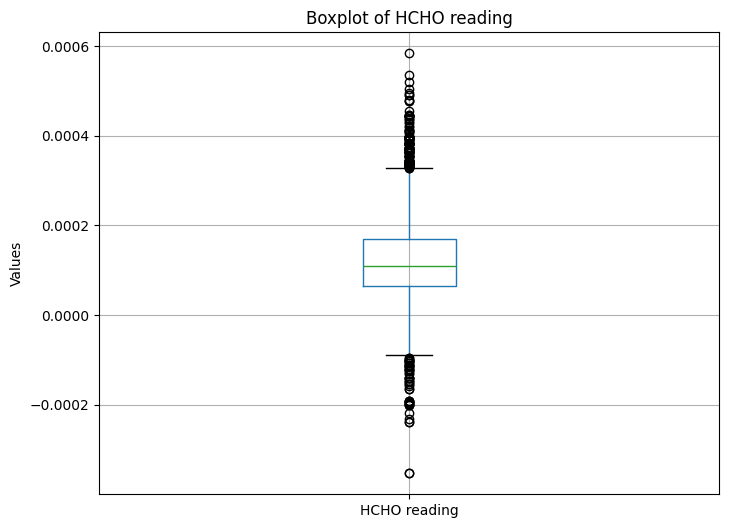

In [34]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pandas_df3 = data_frame3.toPandas()

feature_3 = "HCHO reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df3.boxplot(column=[feature_3])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

In [35]:
# Extracting the HCHO readings from pandas_df_3
hcho_readings_3 = pandas_df3[feature_3]

# Calculating quartiles and IQR
Q1_3 = hcho_readings_3.quantile(0.25)
Q3_3 = hcho_readings_3.quantile(0.75)
IQR_3 = Q3_3 - Q1_3

# Defining outlier thresholds
lower_threshold_3 = Q1_3 - 1.5 * IQR_3
upper_threshold_3 = Q3_3 + 1.5 * IQR_3

# Counting outliers
outliers_frequency_3 = ((hcho_readings_3 < lower_threshold_3) | (hcho_readings_3 > upper_threshold_3)).sum()

print("Frequency of outliers in feature_3:", outliers_frequency_3)

Frequency of outliers in feature_3: 179


In [36]:
# Define the Winsorization function
def winsorize(series, lower_threshold, upper_threshold):
    # Winsorize the series
    winsorized_series = series.clip(lower=lower_threshold, upper=upper_threshold)
    return winsorized_series

# Apply Winsorization to handle outliers
pandas_df3[feature_3] = winsorize(pandas_df3[feature_3], lower_threshold_3, upper_threshold_3)

# Recalculate the frequency of outliers after Winsorization
outliers_after_winsorization_3 = ((pandas_df3[feature_3] < lower_threshold_3) | (pandas_df3[feature_3] > upper_threshold_3)).sum()

print("Frequency of outliers after Winsorization in feature_3:", outliers_after_winsorization_3)


Frequency of outliers after Winsorization in feature_3: 0


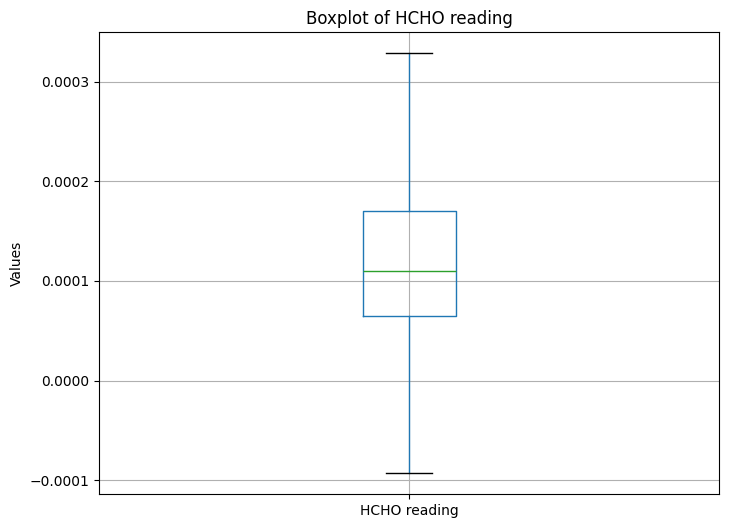

In [37]:
# After handling the outlier of data frame 3
import matplotlib.pyplot as plt

feature_3 = "HCHO reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df3.boxplot(column=[feature_3])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

In [38]:
import pandas as pd

dates = pandas_df3['Current Date']

for date in sorted(dates.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [39]:
import pandas as pd

dates = pandas_df3['Next Date']

for date in sorted(dates.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [40]:
pandas_df3

,HCHO reading,Location,Current Date,Next Date
0,0.000088,Kurunegala Proper,2019-01-01,2019-01-02
1,0.000058,Jaffna Proper,2019-01-01,2019-01-02
2,0.000019,"Bibile, Monaragala",2019-01-02,2019-01-03
3,0.000137,Kurunegala Proper,2019-01-02,2019-01-03
4,0.000102,Jaffna Proper,2019-01-02,2019-01-03
...,...,...,...,...
5472,0.000158,Kurunegala Proper,2023-12-30,2023-12-31
5473,0.000117,Jaffna Proper,2023-12-30,2023-12-31
5474,0.000117,"Bibile, Monaragala",2023-12-31,2024-01-01
5475,0.000065,Kurunegala Proper,2023-12-31,2024-01-01


In [41]:
# Concatenate DataFrames vertically
concat_df = pd.concat([pandas_df1, pandas_df2, pandas_df3], axis=0)

# Resetting index if needed
concat_df.reset_index(drop=True, inplace=True)

print(concat_df)

       HCHO reading             Location Current Date   Next Date
0          0.000263     Deniyaya, Matara   2019-01-01  2019-01-02
1          0.000263  Nuwara Eliya Proper   2019-01-01  2019-01-02
2          0.000263       Colombo Proper   2019-01-02  2019-01-03
3          0.000006     Deniyaya, Matara   2019-01-02  2019-01-03
4          0.000006  Nuwara Eliya Proper   2019-01-02  2019-01-03
...             ...                  ...          ...         ...
12774      0.000158    Kurunegala Proper   2023-12-30  2023-12-31
12775      0.000117        Jaffna Proper   2023-12-30  2023-12-31
12776      0.000117   Bibile, Monaragala   2023-12-31  2024-01-01
12777      0.000065    Kurunegala Proper   2023-12-31  2024-01-01
12778      0.000065        Jaffna Proper   2023-12-31  2024-01-01

[12779 rows x 4 columns]


In [42]:
# Check null values in each column of the Pandas DataFrame
print(concat_df.isnull().sum())

HCHO reading    0
Location        0
Current Date    0
Next Date       0
dtype: int64


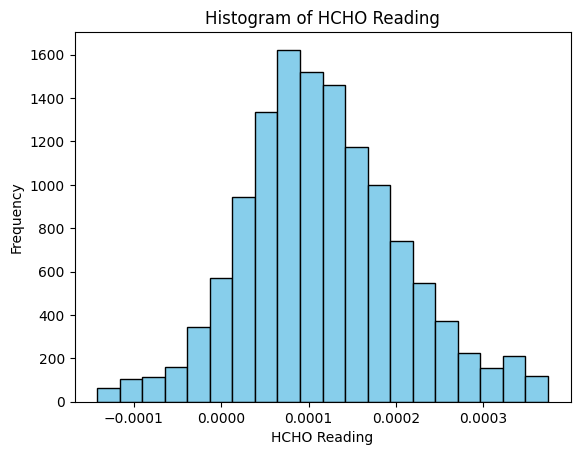

In [43]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(concat_df['HCHO reading'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.title('Histogram of HCHO Reading')

# Show the plot
plt.show()

In [44]:
concat_df

,HCHO reading,Location,Current Date,Next Date
0,0.000263,"Deniyaya, Matara",2019-01-01,2019-01-02
1,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
2,0.000263,Colombo Proper,2019-01-02,2019-01-03
3,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03
4,0.000006,Nuwara Eliya Proper,2019-01-02,2019-01-03
...,...,...,...,...
12774,0.000158,Kurunegala Proper,2023-12-30,2023-12-31
12775,0.000117,Jaffna Proper,2023-12-30,2023-12-31
12776,0.000117,"Bibile, Monaragala",2023-12-31,2024-01-01
12777,0.000065,Kurunegala Proper,2023-12-31,2024-01-01


In [53]:
concat_df['Current Date'] = pd.to_datetime(concat_df['Current Date'])
concat_df['Next Date'] = pd.to_datetime(concat_df['Next Date'])

In [54]:
# Extracting year and month for seasonal analysis
concat_df['Year'] = concat_df['Current Date'].dt.year
concat_df['Month'] = concat_df['Current Date'].dt.month

In [55]:
# Grouping data by year and month for seasonal analysis
seasonal_data = concat_df.groupby(['Year', 'Month'])['HCHO reading'].mean().reset_index()

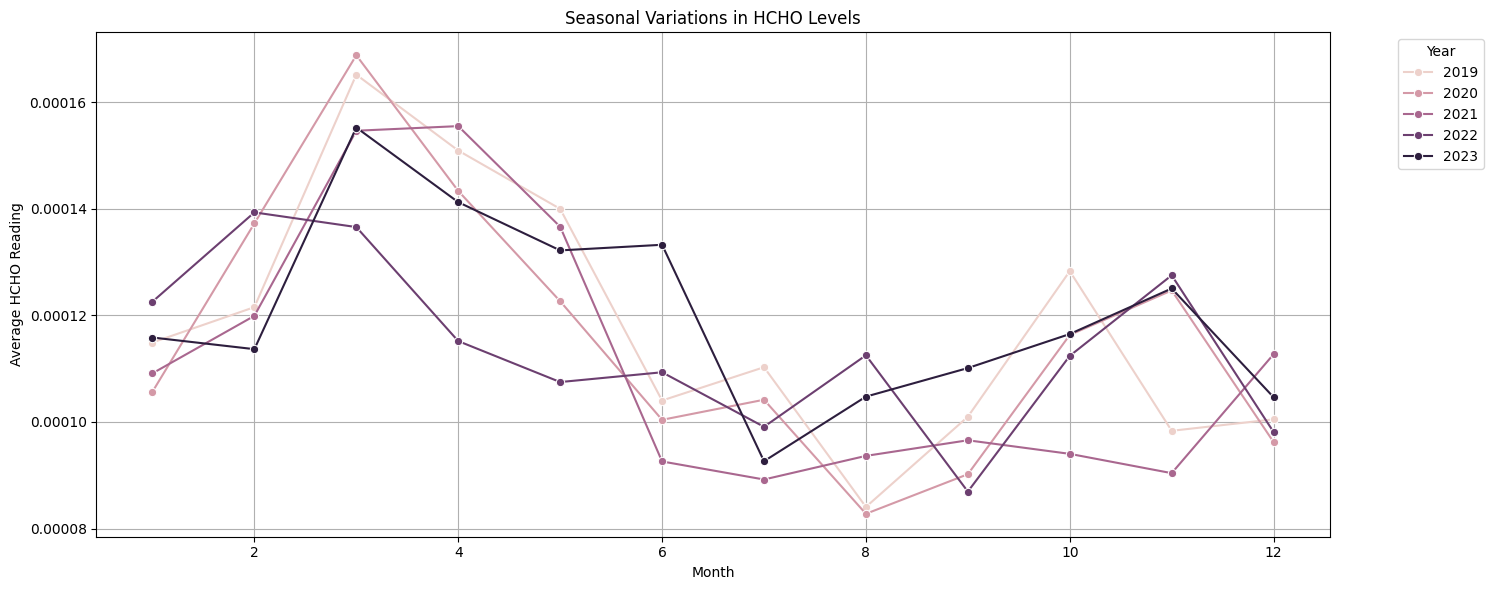

In [56]:
import seaborn as sns
# Plotting seasonal variations
plt.figure(figsize=(15, 6))
sns.lineplot(x="Month", y="HCHO reading", hue="Year", data=seasonal_data, marker='o')
plt.title('Seasonal Variations in HCHO Levels')
plt.xlabel('Month')
plt.ylabel('Average HCHO Reading')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
# Path that i want to save 
save_path = "Dataset/Concat_dataframe.csv"
# Save the pandas df to csv
concat_df.to_csv(save_path, index=False)